In [1]:
import matplotlib.pyplot as plt
import copy
import json
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from my_utilities import read_data, predict_and_retrain, my_bar_plot

Read the data:

In [2]:
whole_data, tr_data, ts_data = read_data()

Check if the series is **stationary**:<br>
Use _Augmented Dickey-Fuller test_ (ADF): The intuition behind the
test is that if the series is characterised by a unit root
process then the lagged level of the series ($y_{t-1}$) will provide
no relevant information in predicting the change in $y_{t}$.

In [10]:
adf = adfuller(whole_data)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

6
ADF: -21.61637819803612
p-value: 0.0
Critical values:


The series looks stationary, it is possible to make forecast with an
autoregressive model.

Now plot the **autocorrelation** and the **partial autocorrelation**
to understand visually which lags have more influence on the current
value $y_{t}$:

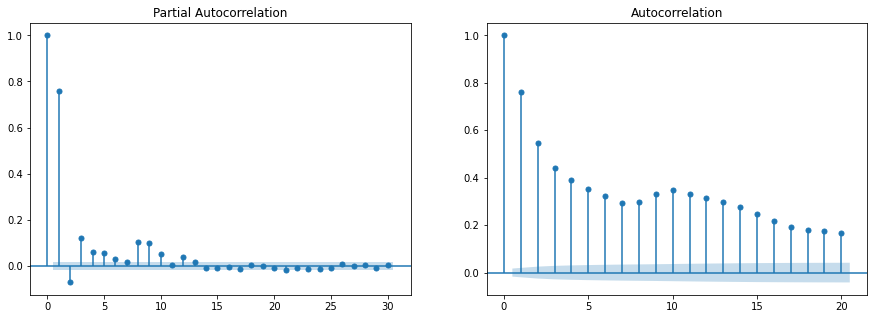

In [4]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
plot_pacf(tr_data, lags=30, ax=ax[0])
plot_acf(tr_data, lags=20, ax=ax[1])
plt.show()

It looks like an **AR** model is a good choice.

### Model selection:
- AR: try the following orders: 2, 3, 5, 10
- ARMA: try the following orders: AR(3)+MA(1)

All the models will be trained with the training data (first 3 months)
and tested on the test data (last 1.5 month) with the following
retraining schedules:
- Retrain after every prediction on the test set
- Retrain every time the error is > 10
- Retrain every time the error is > 50
- Retrain every time the error is > 100

The error is measured in terms of _Mean Absolute Error_ (MAE)

In [5]:
# combinations of orders of te models to test
combos = [
    {"order_ar": 2, "order_ma": 0, "err_thresh": 0},
    {"order_ar": 2, "order_ma": 0, "err_thresh": 10},
    {"order_ar": 2, "order_ma": 0, "err_thresh": 50},
    {"order_ar": 2, "order_ma": 0, "err_thresh": 100},
    {"order_ar": 3, "order_ma": 0, "err_thresh": 0},
    {"order_ar": 3, "order_ma": 0, "err_thresh": 10},
    {"order_ar": 3, "order_ma": 0, "err_thresh": 50},
    {"order_ar": 3, "order_ma": 0, "err_thresh": 100},
    {"order_ar": 5, "order_ma": 0, "err_thresh": 0},
    {"order_ar": 5, "order_ma": 0, "err_thresh": 10},
    {"order_ar": 5, "order_ma": 0, "err_thresh": 50},
    {"order_ar": 5, "order_ma": 0, "err_thresh": 100},
    {"order_ar": 10, "order_ma": 0, "err_thresh": 0},
    {"order_ar": 10, "order_ma": 0, "err_thresh": 10},
    {"order_ar": 10, "order_ma": 0, "err_thresh": 50},
    {"order_ar": 10, "order_ma": 0, "err_thresh": 100},
    {"order_ar": 3, "order_ma": 1, "err_thresh": 0},
    {"order_ar": 3, "order_ma": 1, "err_thresh": 10},
    {"order_ar": 3, "order_ma": 1, "err_thresh": 50},
    {"order_ar": 3, "order_ma": 1, "err_thresh": 100},
]

### Training:

In [ ]:
# Training of the models -> results saved on json files
for curr in combos:
    predict_and_retrain(**curr, tr_data=copy.deepcopy(tr_data), ts_data=ts_data, retrain=True)

### Analyze the results:

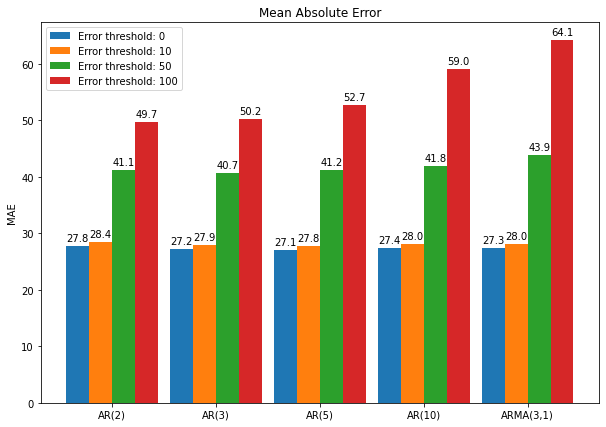

In [7]:
# read the data from files and put it in some lists for the bar-plot
labels = []
series = {0: [], 10: [], 50: [], 100: []}
filenames = ["individual_results_files/" + str(c["order_ar"]) + "_" + str(c["order_ma"]) + "_" + str(c["err_thresh"]) +
             "_retrain.json" for c in combos]

for i, fn in enumerate(filenames):
    with open(fn, 'r') as f:
        mae = json.load(f)
        mae = round(mae["mae"], 1)
        series[combos[i]["err_thresh"]].append(mae)

    if combos[i]["order_ma"] == 0:
        s = "AR({})".format(combos[i]["order_ar"])
    else:
        s = "ARMA({},{})".format(combos[i]["order_ar"], combos[i]["order_ma"])

    if s not in labels:
        labels.append(s)

# call the function to generate the bar-plots
my_bar_plot(series, labels)

#### Show the predictions:
Compare the predictions of the **last day of data** with the different
retraining policies. It is shown the best model for each error threshold.

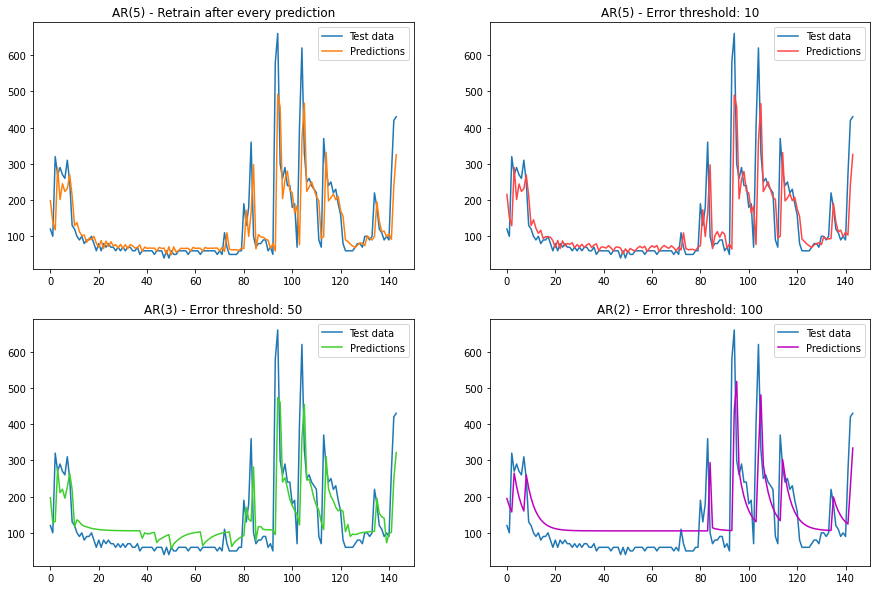

In [48]:
models_data = {}
dir = "individual_results_files/"
thresh_to_idx = {0: 0, 1: 10, 2: 50, 3: 100}
best_models = {0: "5_0_0_retrain.json", 10: "5_0_10_retrain.json",
               50: "3_0_50_retrain.json", 100: "2_0_100_retrain.json"}
for thresh, filename in best_models.items():
    with open(dir + filename) as f:
        models_data[thresh] = json.load(f)

n = 24 * 6
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(ts_data[-n:], label="Test data")
axs[0, 0].plot(models_data[thresh_to_idx[0]]["predictions"][-n:], label="Predictions")
axs[0, 0].set_title("AR(5) - Retrain after every prediction")
axs[0, 0].legend()

axs[0, 1].plot(ts_data[-n:], label="Test data")
axs[0, 1].plot(models_data[thresh_to_idx[1]]["predictions"][-n:], label="Predictions", color='#FE4646')
axs[0, 1].set_title("AR(5) - Error threshold: 10")
axs[0, 1].legend()

axs[1, 0].plot(ts_data[-n:], label="Test data")
axs[1, 0].plot(models_data[thresh_to_idx[2]]["predictions"][-n:], label="Predictions", color='#3DCF2B')
axs[1, 0].set_title("AR(3) - Error threshold: 50")
axs[1, 0].legend()

axs[1, 1].plot(ts_data[-n:], label="Test data")
axs[1, 1].plot(models_data[thresh_to_idx[3]]["predictions"][-n:], label="Predictions", color='m')
axs[1, 1].set_title("AR(2) - Error threshold: 100")
axs[1, 1].legend()
